In [7]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.9/102.9 kB 2.6 MB/s eta 0:00:00


In [10]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from random import choice
import random
from typing import Union
import math
import numpy as np
from matplotlib.animation import FuncAnimation


class Car:
    def __init__(self, unique_id, environment) -> None:
        """
        Initializes a car with a unique id, environment, and path.

        Parameters
        ----------
        unique_id : int
            Unique identifier for the car.
        environment : Environment
            The environment in which the car exists.
        """
        self.unique_id = unique_id
        self.environment = environment
        self.path, self.destination = self.assign_path()
        self.current_location = 0

    def assign_path(self) -> Union[list, int]:
        """
        Assigns random destinations for cars.

        Returns
        -------
        path : list
            List of nodes representing the assigned path.
        start : int
            Starting node for the assigned path.
        destination : int
            Ending node for the assigned path.
        """
        G = self.environment.G
        start = choice(list(G.nodes()))
        destination = choice(list(G.nodes()))
        path = self.create_path(start, destination)
        return path, path[-1]

    def create_path(self, source, target) -> list:
        """
        Return list of nodes if G has a path from source to target.
        Otherwise reassigns destination randomly.

        Returns
        -------
        shortest : list
            List of nodes representing the shortest path.
        """
        try:
            shortest = nx.shortest_path(self.environment.G, source, target)

        except nx.NetworkXNoPath:
            possible_targets = set(self.environment.G.nodes()) - {source}
            target = choice(list(possible_targets))
            shortest = nx.shortest_path(self.environment.G, source, target)
        return shortest

    def step(self) -> None:
        if self.current_location == self.destination:
            # remove car from environment
            self.environment.cars.remove(self)
            pass

        else:
            current_node = self.path.pop(0)
            next_node = self.path[0]

            # Logistic function for determining whether the car can move
            probability_of_movement = self.calculate_logistic_probability(
                current_node, next_node
            )

            if random.random() < probability_of_movement:
                # car stays at the same spot
                self.path.insert(0, current_node)

            else:
                # car moves to the next node
                self.current_location = next_node
                # increase traffic count for the edge
                if len(self.path) > 1:
                    self.environment.edges_count[(current_node, next_node, 0)] += 1

    def calculate_logistic_probability(self, node1, node2) -> float:
        kappa = -0.1  # decay factor
        inherent_capacity = self.get_edge_attribute(node1, node2, "max capacity")

        load = self.environment.retrieve_edge_count(node1, node2)
        logistic_input = kappa * (load - inherent_capacity)

        # Logistic function calculation
        probability_of_movement = 1 / (1 + math.exp(-logistic_input))
        return probability_of_movement

    def get_edge_attribute(self, node1, node2, attribute) -> any:
        """
        Returns the value of the specified edge attribute.

        Returns
        -------
        value : any
            The value of the specified edge attribute.
        """
        return self.environment.get_edge_attribute(node1, node2, attribute)


class Environment:
    def __init__(self, address) -> None:
        """
        Initializes the environment with a road network loaded from a real address.

        Parameters
        ----------
        address : str
            The real address used to load the road network.
        """
        self.cars = []
        self.G = self.load_road_network(address)
        self.congestion = self.initialize_congestion()
        self.edges_count = self.initialize_edges_count()

    def initialize_edges_count(self) -> dict:
        edges_count = {}
        for u, v, k, data in self.G.edges(data=True, keys=True):
            edges_count[(u, v, 0)] = 0

        return edges_count

    def initialize_congestion(self) -> dict:
        congestion = {}
        for u, v, k, data in self.G.edges(data=True, keys=True):
            congestion[(u, v, 0)] = []
        return congestion

    def retrieve_edge_count(self, node1, node2) -> int:
        return self.edges_count[(node1, node2, 0)]

    def load_road_network(self, address) -> nx.Graph:
        """
        Loads a network from a real address through the OpenStreetMaps API.
        (assume time is inversely proportional to speed limit with a default of 30 km/h).

        Returns
        -------
        G : NetworkX graph
            The loaded road network graph.
        """
        # Load network from address
        G = ox.graph_from_address(address, dist=1000, network_type="drive")

        # Add travel time attribute to each edge
        for u, v, k, data in G.edges(data=True, keys=True):
            speed = data.get(
                "maxspeed", 30
            )  # Gets the value of the key "maxspeed" from the edge dictionary or 30 if it doesn't exist
            if isinstance(
                speed, list
            ):  # There can be multiple speed limits; take the first one as representative
                speed = speed[0]
            data["travel_time"] = data["length"] / (
                float(speed) * 1000 / 60
            )  # Length in meters, speed in km/h, result in minutes

            # Add max capacity for each edge
            data["max capacity"] = data["length"] / 7.5

        return G

    def get_edge_attribute(self, node1, node2, attribute) -> any:
        """
        Returns the value of the specified edge attribute.

        Returns
        -------
        value : any
            The value of the specified edge attribute.
        """
        return self.G.edges[node1, node2, 0][attribute]

    def add_car(self, car) -> None:
        """
        Adds a car to the environment.

        Parameters
        ----------
        car : Car
            The car to be added to the environment.
        """
        self.cars.append(car)

    def step(self) -> None:
        """
        Updates the simulation state for each agent (car).
        """
        for car in self.cars:
            car.step()
        self.calculate_congestion_rates()

    def calculate_congestion_rates(self) -> dict:
        for u, v, k, data in self.G.edges(data=True, keys=True):
            load = self.edges_count[(u, v, 0)]
            max_capacity = data["max capacity"]
            congestion_rate = load / (max_capacity + 1e-9)  # Avoid division by zero
            self.congestion[(u, v, 0)].append(congestion_rate)

    def get_all_edge_car_counts(self) -> dict:
        return self.edges_count

    def get_all_edge_betweenness(self) -> dict:
        return nx.edge_betweenness_centrality(self.G)

    def visualize_edges_with_traffic(self, ax):
        edge_colors = []
        edge_widths = []

        counts = self.get_all_edge_car_counts()
        max_count = max(counts.values())

        for u, v, k, data in self.G.edges(keys=True, data=True):
            count = counts.get((u, v, 0), 0)
            edge_colors.append(
                plt.cm.Reds(count / (max_count + 1e-9))
            )  # Add a small constant to avoid division by zero
            edge_widths.append(1 + count)

        ox.plot_graph(self.G, ax=ax, edge_color=edge_colors, edge_linewidth=edge_widths)


class Simulation:
    def __init__(self, num_cars, num_steps, address) -> None:
        """
        Initializes the simulation with a specified number of cars and simulation steps.

        Parameters
        ----------
        num_cars : int
            The number of cars in the simulation.
        num_steps : int
            The number of simulation steps to run.
        """
        self.environment = Environment(address)
        self.create_agents(num_cars)
        self.num_cars = num_cars
        self.num_steps = num_steps

    def create_agents(self, num_cars) -> None:
        """
        Creates and adds cars to the environment.

        Parameters
        ----------
        num_cars : int
            The number of cars to create and add to the environment.
        """
        for i in range(num_cars):
            agent = Car(unique_id=i, environment=self.environment)
            self.environment.add_car(agent)

    def run(self, num_steps) -> None:
        """
        Runs the simulation for a specified number of steps.

        Parameters
        ----------
        num_steps : int
            The number of simulation steps to run.
        """
        for step in range(num_steps):
            self.environment.step()

    def visualize_network(self) -> Union[plt.Figure, plt.Axes]:
        """
        Visualizes the road network using OSMnx.

        Returns
        -------
        fig, ax : matplotlib.figure.Figure, matplotlib.axes.Axes
        """

        fig, ax = ox.plot_graph(self.environment.G, figsize=(10, 10))
        return fig, ax

    def plot_congestion_vs_betweenness(self) -> None:
        """
        Plot congestion rate against betweenness centrality for each edge.
        """
        betweenness = self.environment.get_all_edge_betweenness()

        congestion_rates = []
        betweenness_values = []

        for edge_key, congestion_rate in self.environment.congestion.items():
            betweenness_value = betweenness.get(edge_key, 0)
            congestion_rates.append(np.mean(congestion_rate))
            betweenness_values.append(betweenness_value)

        plt.scatter(betweenness_values, congestion_rates, alpha=0.5)
        plt.xlabel("Betweenness Centrality")
        plt.ylabel("Congestion Rate")
        plt.title(
            f"Congestion Rate vs Betweenness Centrality for {self.num_cars} cars over {self.num_steps} steps"
        )
        plt.show()

    def animate_simulation_with_traffic(self):
        fig, ax = ox.plot_graph(
            self.environment.G, figsize=(10, 10), show=False, close=False
        )
        self.environment.visualize_edges_with_traffic(ax)

        def update(frame):
            plt.cla()  # Clear the current axis
            self.environment.step()
            self.plot_cars(ax)
            self.environment.visualize_edges_with_traffic(ax)

        ani = FuncAnimation(fig, update, frames=self.num_steps, interval=1000)
        plt.show()



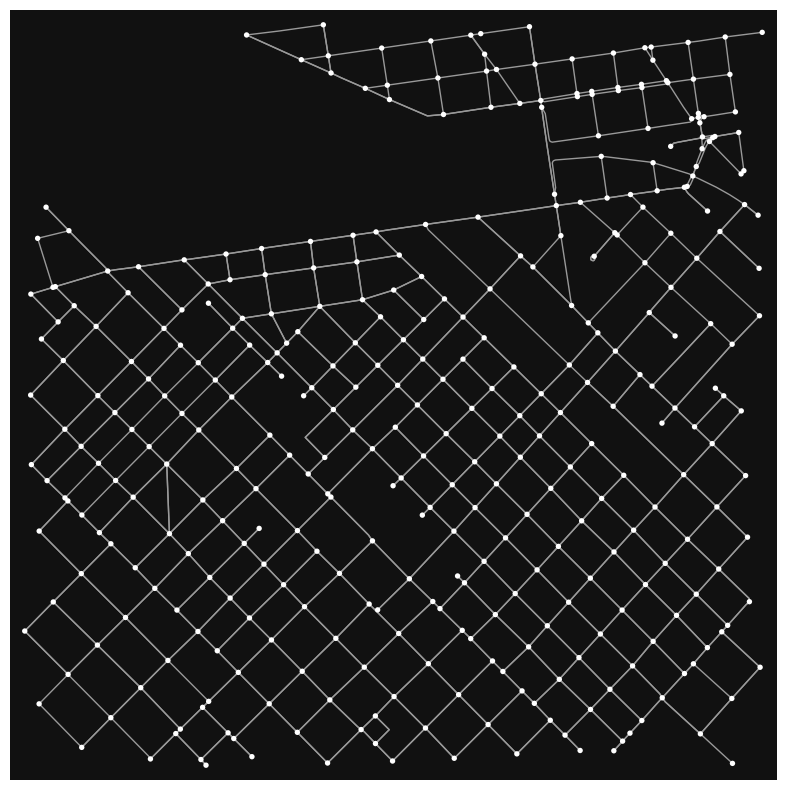

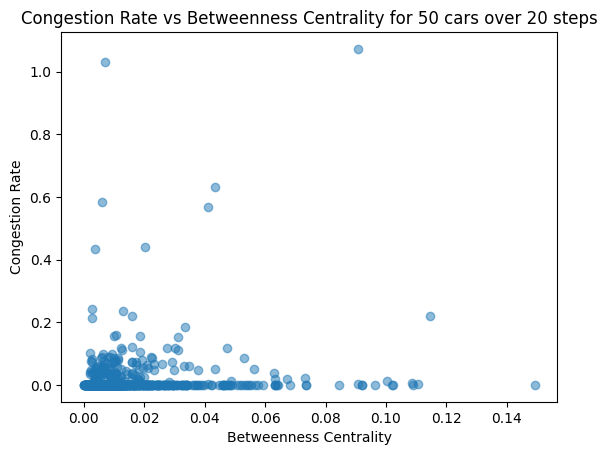

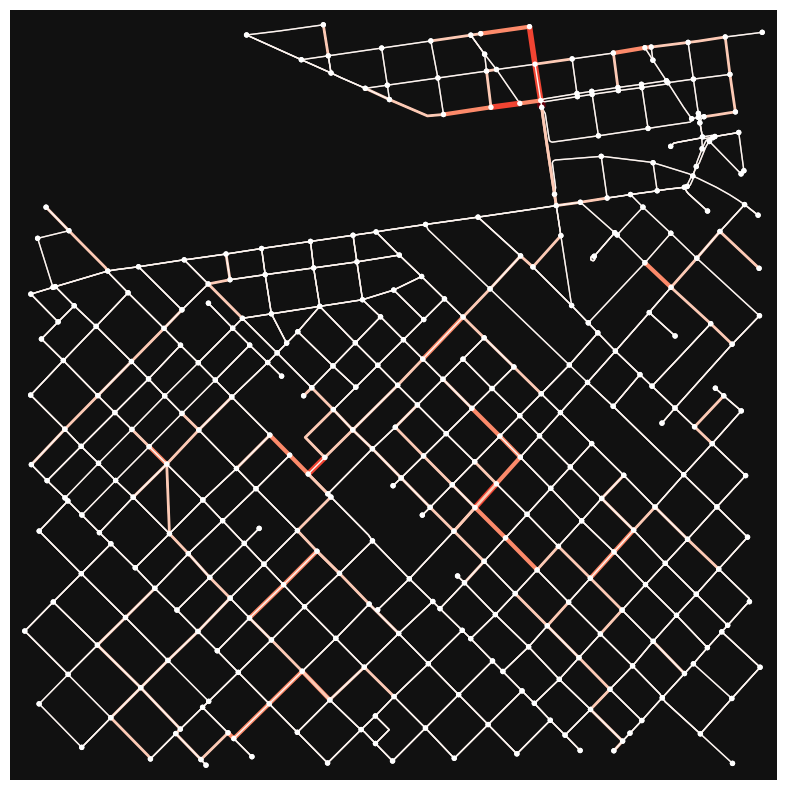

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [11]:
# Params
num_cars = 50
num_steps = 20
address1 = "Adalbertstraße 58, Berlin, Germany"
address2 = "Esmeralda 920, Buenos Aires, Argentina"

# Run simulation
sim = Simulation(num_cars=num_cars, num_steps=num_steps, address=address2)
sim.run(num_steps=num_steps)
sim.visualize_network()
sim.plot_congestion_vs_betweenness()
sim.animate_simulation_with_traffic()


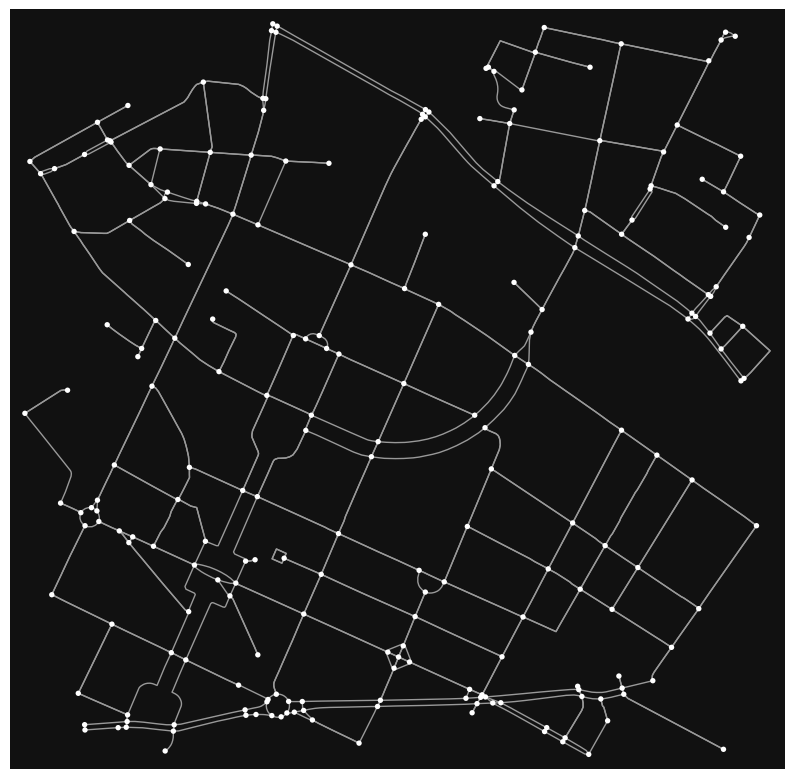

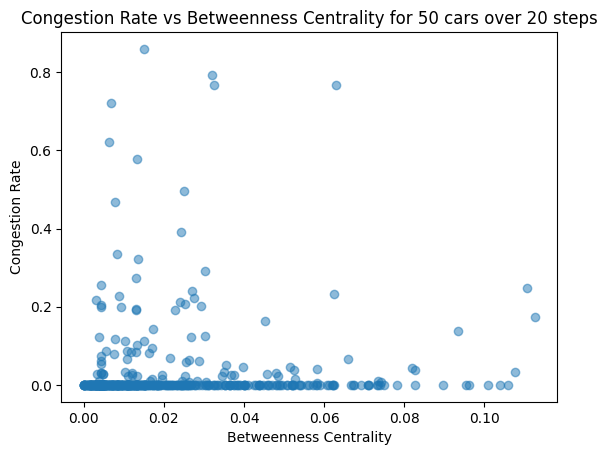

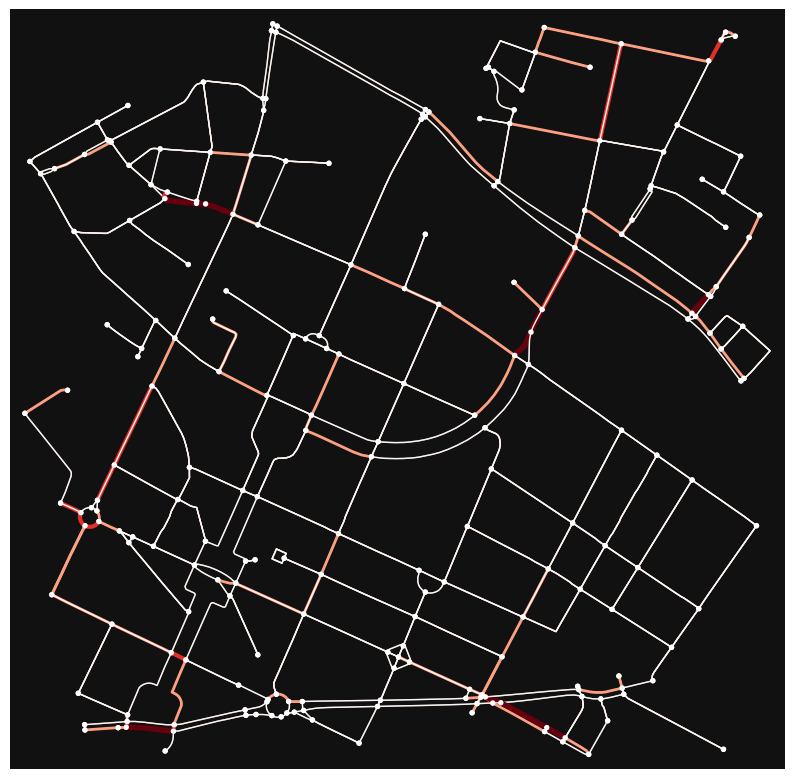

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [12]:
# Params
num_cars = 50
num_steps = 20
address1 = "Adalbertstraße 58, Berlin, Germany"

# Run simulation
sim = Simulation(num_cars=num_cars, num_steps=num_steps, address=address1)
sim.run(num_steps=num_steps)
sim.visualize_network()
sim.plot_congestion_vs_betweenness()
sim.animate_simulation_with_traffic()
